# QC script to calculate sharpness metric for images in a plate

The following script will access the IDR images in a facility manager's context,

The QC script does the following,

1. Extracts Images from OMERO (in this case IDR)
2. Calcualtes sharpness based on the algorithm defined in the following publication,
  * [Image Sharpness Measure for Blurred Images in Frequency Domain] (https://doi.org/10.1016/j.proeng.2013.09.086)
3. Creates a numpy array of the sharpness scores for every well, 
  * seperately for every field and every channel
  * the numpy array is then reshaped to the same dimensions of the plate, ex: 96 well plates will have a numpy array 
    with 8rows and 12columns.
4. Plots a heatmap for every field and every channel, and arranges all plots within a subplot.
5. Exports the heatmap back to OMERO in the following ways,
  * Saves the ["plate_name" + "heatmap.png"] and attaches it to the appropriate plate as a file attachment.
  * Saves the numpy array as an image back to OMERO and a secondary script "createOMEROFigures" can be used to create 
    figures in OMERO.figures in the same layout as seen in the ["plate_name" + "heatmap.png"]

***Import Packages***

In [1]:
from PIL import Image
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import decimal
import seaborn as sns
from mpl_toolkits.axes_grid1 import AxesGrid
from numpy import array, int8
from skimage import feature
from scipy.ndimage import convolve
from scipy import misc, fftpack

***Import BlitzGateway***

In [2]:
from omero.gateway import BlitzGateway

***Server credentials and plate identifier***

In [3]:
USERNAME = ""
PASSWORD = ""
HOST = ""
PORT = 
plateId = 

***Create connection***

In [40]:
conn = BlitzGateway(USERNAME, PASSWORD, host=HOST, port=PORT)
conn.connect()
conn.setSecure(True);
conn.c.enableKeepAlive(300)

***Fetch plate object and print details***

In [5]:
plate = conn.getObject("Plate", plateId)
print "\nNumber of fields:", plate.getNumberOfFields()
print "\nGrid size:", plate.getGridSize()
print "\nWells in Plate:", plate.getName()


Number of fields: (0L, 3L)

Grid size: {'rows': 8L, 'columns': 12L}

Wells in Plate: PNL_Representative_Data_Set_96_Well


***Alogrithm List***

In [17]:
class AlgorithmList:
    def fourierBasedSharpnessMetric(self):
        fftimage = np.fft.fft2(plane)
        fftshift = np.fft.fftshift(fftimage)
        fftshift = np.absolute(fftshift)
        M = np.amax(fftshift)
        Th = (fftshift > (M/float(1000))).sum()
        sharpness = Th/(float(image.getSizeX())*float(image.getSizeY()))
        return sharpness*10000
    def gradientBasedSharpnessMetric(self):
        gy, gx = np.gradient(plane)
        gnorm = np.sqrt(gx**2 + gy**2)
        sharpness = np.average(gnorm)
        return sharpness
    def edgeBasedSharpnessMetric(self):
        edges1 = feature.canny(plane, sigma=3)
        kernel = np.ones((3, 3))
        kernel[1, 1] = 0
        sharpness = convolve(edges1, kernel, mode="constant")
        sharpness[edges1 != 0].sum()
        return sharpness

***Iterative calculations for the whole plate***

In [19]:
chnames = None
cntr = 0
fields = 0
for well in plate.listChildren():
    index = well.countWellSample()
          
    #Hack for writing it into an image, will be used for making omero.figures (split-view) in an automated manner 
    size_z = index
#     for fields in xrange(0, index):
    image = well.getImage(fields)
    if chnames is None:
        chnames = [ch.getLabel() for ch in image.getChannels(True)]
    pixels = image.getPrimaryPixels()
    size_c = image.getSizeC();
    if cntr==0:
        result_array = np.zeros((96, size_c, 4), dtype=float);
    for ch in xrange(0, size_c):
        plane = pixels.getPlane(0, ch, 0)
        sharpness = AlgorithmList().fourierBasedSharpnessMetric()
        result_array[((well.row)*12)+well.column, fields, ch] = sharpness
        tempvalue = result_array[((well.row)*12)+well.column, fields, ch]
        wellid = ((well.row)*12) + well.column
        fieldid = (fields+ch*4)
        cntr=cntr+1;
        print "  Well: ", well.row, well.column, " Fields:", index , " Channels:", ch, " SharpnessScore:", sharpness

  Well:  7 3  Fields: 4  Channels: 0  SharpnessScore: 126.667022705
  Well:  7 3  Fields: 4  Channels: 1  SharpnessScore: 5.67436218262
  Well:  7 3  Fields: 4  Channels: 2  SharpnessScore: 120.191574097
  Well:  7 3  Fields: 4  Channels: 3  SharpnessScore: 912.084579468
  Well:  6 9  Fields: 4  Channels: 0  SharpnessScore: 157.718658447
  Well:  6 9  Fields: 4  Channels: 1  SharpnessScore: 3.95774841309
  Well:  6 9  Fields: 4  Channels: 2  SharpnessScore: 15.9358978271
  Well:  6 9  Fields: 4  Channels: 3  SharpnessScore: 847.749710083
  Well:  0 7  Fields: 4  Channels: 0  SharpnessScore: 136.585235596
  Well:  0 7  Fields: 4  Channels: 1  SharpnessScore: 3.74794006348
  Well:  0 7  Fields: 4  Channels: 2  SharpnessScore: 11.510848999
  Well:  0 7  Fields: 4  Channels: 3  SharpnessScore: 752.382278442
  Well:  1 6  Fields: 4  Channels: 0  SharpnessScore: 144.939422607
  Well:  1 6  Fields: 4  Channels: 1  SharpnessScore: 8.00132751465
  Well:  1 6  Fields: 4  Channels: 2  SharpnessSc

  Well:  7 2  Fields: 4  Channels: 1  SharpnessScore: 3.70979309082
  Well:  7 2  Fields: 4  Channels: 2  SharpnessScore: 6.15119934082
  Well:  7 2  Fields: 4  Channels: 3  SharpnessScore: 746.221542358
  Well:  1 5  Fields: 4  Channels: 0  SharpnessScore: 227.975845337
  Well:  1 5  Fields: 4  Channels: 1  SharpnessScore: 18.3963775635
  Well:  1 5  Fields: 4  Channels: 2  SharpnessScore: 31.7859649658
  Well:  1 5  Fields: 4  Channels: 3  SharpnessScore: 462.284088135
  Well:  0 11  Fields: 4  Channels: 0  SharpnessScore: 66.7762756348
  Well:  0 11  Fields: 4  Channels: 1  SharpnessScore: 2.12669372559
  Well:  0 11  Fields: 4  Channels: 2  SharpnessScore: 6.13212585449
  Well:  0 11  Fields: 4  Channels: 3  SharpnessScore: 627.603530884
  Well:  3 6  Fields: 4  Channels: 0  SharpnessScore: 159.83581543
  Well:  3 6  Fields: 4  Channels: 1  SharpnessScore: 4.05311584473
  Well:  3 6  Fields: 4  Channels: 2  SharpnessScore: 14.7914886475
  Well:  3 6  Fields: 4  Channels: 3  Sharpne

  Well:  5 0  Fields: 4  Channels: 2  SharpnessScore: 9.22203063965
  Well:  5 0  Fields: 4  Channels: 3  SharpnessScore: 451.860427856
  Well:  1 4  Fields: 4  Channels: 0  SharpnessScore: 121.402740479
  Well:  1 4  Fields: 4  Channels: 1  SharpnessScore: 9.29832458496
  Well:  1 4  Fields: 4  Channels: 2  SharpnessScore: 21.8105316162
  Well:  1 4  Fields: 4  Channels: 3  SharpnessScore: 760.288238525
  Well:  3 9  Fields: 4  Channels: 0  SharpnessScore: 140.590667725
  Well:  3 9  Fields: 4  Channels: 1  SharpnessScore: 3.09944152832
  Well:  3 9  Fields: 4  Channels: 2  SharpnessScore: 61.8076324463
  Well:  3 9  Fields: 4  Channels: 3  SharpnessScore: 819.091796875
  Well:  2 3  Fields: 4  Channels: 0  SharpnessScore: 56.9534301758
  Well:  2 3  Fields: 4  Channels: 1  SharpnessScore: 26.8077850342
  Well:  2 3  Fields: 4  Channels: 2  SharpnessScore: 40.9984588623
  Well:  2 3  Fields: 4  Channels: 3  SharpnessScore: 542.125701904
  Well:  1 9  Fields: 4  Channels: 0  SharpnessS

  Well:  7 9  Fields: 4  Channels: 3  SharpnessScore: 468.463897705
  Well:  3 8  Fields: 4  Channels: 0  SharpnessScore: 141.658782959
  Well:  3 8  Fields: 4  Channels: 1  SharpnessScore: 2.83241271973
  Well:  3 8  Fields: 4  Channels: 2  SharpnessScore: 13.1511688232
  Well:  3 8  Fields: 4  Channels: 3  SharpnessScore: 781.869888306
  Well:  2 0  Fields: 4  Channels: 0  SharpnessScore: 86.1358642578
  Well:  2 0  Fields: 4  Channels: 1  SharpnessScore: 11.1484527588
  Well:  2 0  Fields: 4  Channels: 2  SharpnessScore: 51.2027740479
  Well:  2 0  Fields: 4  Channels: 3  SharpnessScore: 183.897018433
  Well:  1 8  Fields: 4  Channels: 0  SharpnessScore: 165.233612061
  Well:  1 8  Fields: 4  Channels: 1  SharpnessScore: 3.21388244629
  Well:  1 8  Fields: 4  Channels: 2  SharpnessScore: 14.123916626
  Well:  1 8  Fields: 4  Channels: 3  SharpnessScore: 887.250900269
  Well:  4 3  Fields: 4  Channels: 0  SharpnessScore: 99.7352600098
  Well:  4 3  Fields: 4  Channels: 1  SharpnessSc

***Reshape numpy array and plot heatmaps***

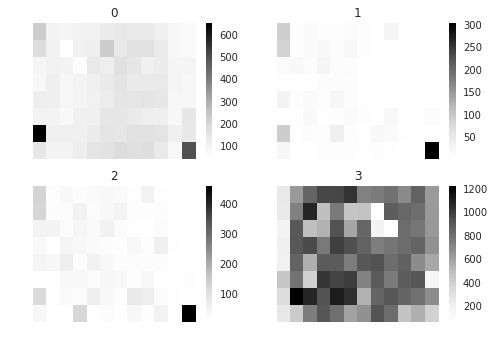

In [48]:
plate_name = plate.getName()
colval = 0
planes = []
cntr = 0
for rowval in range (0, size_c):
#     for colval in range (0, fields):
        # print (result_array[:,colval,rowval])
    data = result_array[:, colval, rowval].reshape(8,12);
    data = np.repeat(data, 20, axis=1)
    data = np.repeat(data, 20, axis=0)
    planes.append(np.uint16(data))
    data = np.flipud(data)
    ax = plt.subplot(2,2,cntr+1)
    plt.pcolor(data)
    plt.axis('off')
    plt.colorbar()
    ax.title.set_text(rowval)
    cntr = cntr + 1
plt.savefig(plate_name + 'SharpnessHeatMaps.png')
plt.show()

***Save Results Back to OMERO as File Attachments***

In [41]:
plate = conn.getObject("Plate", plateId)
file_to_upload = plate_name + "SharpnessHeatMaps.png"   # This file should already exist
with open(file_to_upload, 'w') as f:
    f.write('annotation test')
# create the original file and file annotation (uploads the file etc.)
namespace = "dundee.users.meeting.demo"
print "\nCreating an OriginalFile and FileAnnotation"
file_ann = conn.createFileAnnfromLocalFile(
    file_to_upload, mimetype="text/plain", ns=namespace, desc=None)
print "Attaching FileAnnotation to Plate: ", "File ID:", file_ann.getId(), \
    ",", file_ann.getFile().getName(), "Size:", file_ann.getFile().getSize()
plate.linkAnnotation(file_ann)


Creating an OriginalFile and FileAnnotation
Attaching FileAnnotation to Plate:  File ID: 20051 , PNL_Representative_Data_Set_96_WellSharpnessHeatMaps.png Size: 15


<FileAnnotationWrapper id=20051>

***Create OMERO Image from numpy sequence, feeder for createOMEROFigures script****

In [46]:
size_c = 4
size_z = 1
size_t = 1
def planeGen():
    """generator will yield planes"""
    for p in planes:
        yield p

desc = "Image created from a hard-coded arrays"
i = conn.createImageFromNumpySeq(planeGen(), plate_name + "numpy image", size_z, size_c, size_t, description=desc,dataset=None)
print 'Created new Image:%s Name:"%s"' % (i.getId(), i.getName())

Created new Image:76335 Name:"PNL_Representative_Data_Set_96_Wellnumpy image"


***Close Connection***

In [49]:
conn.close()